## Introduction

Welcome to the DSN Internship Coding Challenge! This assessment will put your Natural Language Processing (NLP) and problem-solving abilities to the test. :

- Section one of the assessmnet will require you to build a text classification model.

Good luck! If you have questions about the framing of the questions, please contact **recruitment@datasciencenigeria.ai**

### How to Use and Submit this Notebook.
- Make a copy of this document and rename it **Firstname_Lastname_DSNInternshipCodingAssessment.ipynb**
- Before attempting to submit, ensure that you have ran all of the cells in your notebook and the output visible.
- Once you’ve completed all tasks, save and download a copy of the notebook as .ipynb
- Submit a link (make sure that the link is set to "Anyone on the internet with the link can view"), the downloaded copy of your final notebook via this [link](https://forms.gle/t8sFNrfAymZUrfJq7).

### What Not to Do.
- Do not share this document with any external party
- No teamwork is permitted
- After submitting a copy of your script, you are not permitted to make any changes to the online version; any discrepancy between the online and submitted copies will render your application null and void.

### Dataset

This is a news [dataset](https://drive.google.com/file/d/1NgPM7_mFCDKnuqI9SamMCrkF1mE5AgAI/view?usp=sharing) which contains 2225 examples of news articles with their respective labels. Use to the link to learn more about the dataset

## Section 1

### Task

**This is to test your knowledge on NLP**

Build and train a machine learning model with the provided dataset to classify the news category or topic. You can use any architecture or model, in this test.

**Make sure to plot the accuracy vs epochs and loss vs epochs graphs**

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import os
import re
import nltk
from markupsafe import escape

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('/content/sample_data/bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


A quick look at our data



In [5]:
df[df["category"] == 'sport']["text"].values[1]

'yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeading in the fa cup third round.  the game - arguably the highlight of the draw - is a potential money-spinner for non-league yeading  who beat slough in the second round. conference side exeter city  who knocked out doncaster on saturday  will travel to old trafford to meet holders manchester united in january. arsenal were drawn at home to stoke and chelsea will play host to scunthorpe. the only other non-league side in the draw are hinckley united  who held brentford to a goalless draw on sunday. they will meet league one leaders luton if they win their replay against martin allen s team at griffin park.  a number of premiership teams face difficult away games against championship sides on the weekend of 8/9 january. third-placed everton visit plymouth  liverpool travel to burnley  crystal palace go to sunderland  fulham face carling cup semi-finalists watford  bolton me

In [6]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(2225, 2)
Unique categories: 5
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [7]:
# descibtion of the dataset
df.describe()

,category,text
count,2225,2225
unique,5,2126
top,sport,kennedy questions trust of blair lib dem leade...
freq,511,2


In [8]:

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

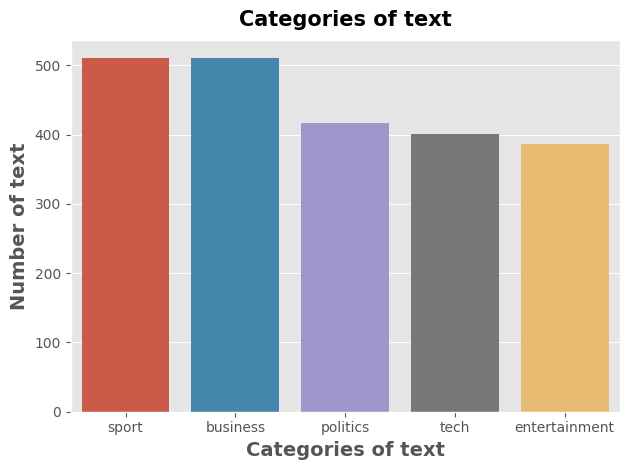

In [9]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(df['category'].value_counts()).reset_index()
sns.barplot(cat_df,x='index',y='category')
plt.title("Categories of text", size=15)
plt.xlabel("Categories of text", size=14)
plt.ylabel("Number of text", size=14)
plt.show()

In [10]:
final_df = df.copy()
final_df['length_of_text'] = final_df['text'].map(lambda x: len(x))
final_df.head()

,category,text,length_of_text
0,tech,tv future in the hands of viewers with home th...,4333
1,business,worldcom boss left books alone former worldc...,1842
2,sport,tigers wary of farrell gamble leicester say ...,1342
3,sport,yeading face newcastle in fa cup premiership s...,2176
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579


In [11]:
# maximum length of text in each category
lenmax_df = final_df.groupby('category')['length_of_text'].max().reset_index().sort_values(by='length_of_text',ascending=False)
lenmax_df.head()

,category,length_of_text
2,politics,25483
1,entertainment,19136
4,tech,16158
3,sport,9471
0,business,5406


(-0.5, 1599.5, 599.5, -0.5)

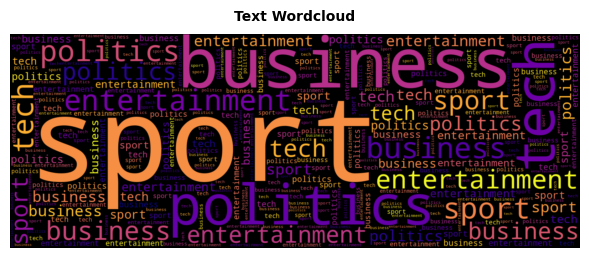

In [12]:
# wordcloud of categories of text in our dataset
plt.figure(figsize=(6,6))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS).generate(' '.join(final_df.category))

plt.title("Text Wordcloud", size=10, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

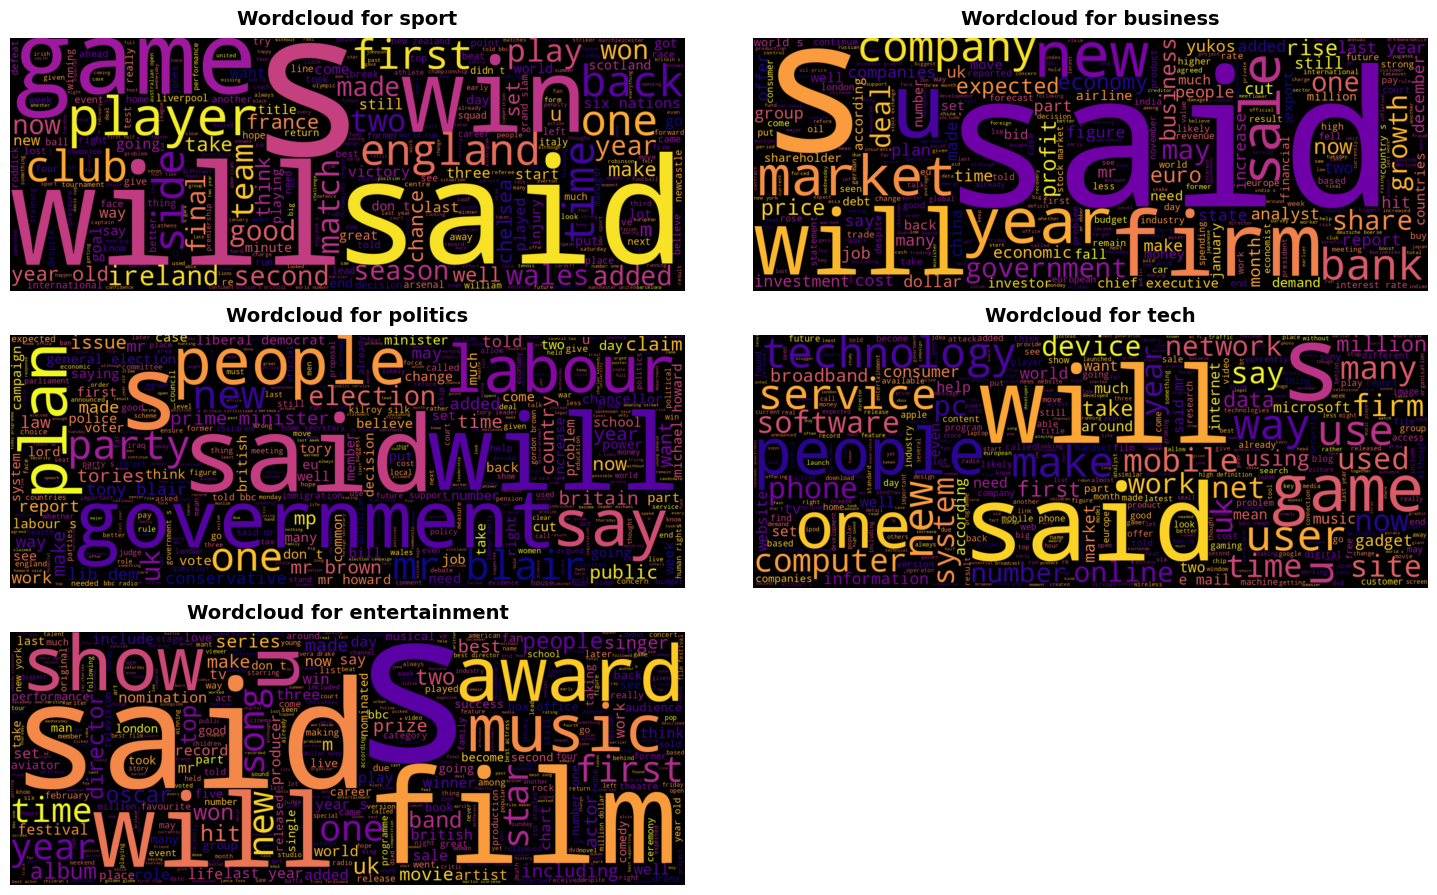

In [13]:
# create new dataframe of category and length of each text in that categories
new_df = final_df.copy()
new_df.drop('length_of_text', inplace=True, axis=1)

# list of categories in out dataset
categories = cat_df['index'].to_list()

# list of news articles of each top 10 categories list
text_list = []

for i in categories:
    cat_ndf = new_df[new_df['category'] == i]
    cat_array = cat_ndf['text'].values  # array of news articles text in each category
    text_list.append(cat_array)

# create a wordcloud instance
wc1 = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(text_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for {j}")
    plt.axis('off')

In [14]:
# start with removing some data from politics dataframe ndf
politics_list = list(new_df[new_df['category'] == 'politics'].index)
list_1 = politics_list

# drop the  labels from the dataset
ndf2 = new_df.copy()
ndf2.drop(list_1, axis=0, inplace=True)

In [15]:
ndf2

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2218,sport,davies favours gloucester future wales hooker ...
2219,business,beijingers fume over parking fees choking traf...
2220,business,cars pull down us retail figures us retail sal...
2222,entertainment,rem announce new glasgow concert us band rem h...


In [16]:
# clean the text data using regex and data cleaning function
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()

    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]

    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))

    return ' '.join(sentence)

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:

new_df.text = new_df.text.apply(lambda x: datacleaning(x))

In [18]:
final_df.text = final_df.text.apply(lambda x: datacleaning(x))

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [21]:
train_data, test_data = train_test_split(final_df, test_size=1-TRAIN_SIZE,
                                         random_state=42) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1780
Test Data size 445


In [22]:
train_data.head(10)

,category,text,length_of_text
1490,entertainment,farrell due make us tv debut actor colin farre...,1343
2001,business,china continue rapid growth china s economy ex...,2136
1572,business,ebbers aware worldcom fraud former worldcom bo...,2365
1840,entertainment,school tribute tv host carson people turn sund...,1009
610,tech,broadband fuel online expression fast web acce...,2035
23,sport,cole face lengthy injury layoff aston villa s ...,824
1904,tech,half measure halflife halflife possibly live h...,5707
427,tech,microsoft take desktop search microsoft enter ...,1429
861,tech,long life promise laptop pcs scientists work w...,3018
988,sport,barcelona title hop hit loss barcelona s pursu...,1110


In [23]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 22459


In [23]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0rc1
    Uninstalling keras-2.12.0rc1:
      Successfully uninstalled keras-2.12.0rc1


  Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.13.1 which is incompatible.


In [24]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1780, 30)
Testing X Shape: (445, 30)


In [ ]:
labels = train_data.category.unique().tolist()

In [25]:
encoder = LabelEncoder()
encoder.fit(train_data.category.to_list())

y_train = encoder.transform(train_data.category.to_list())
y_test = encoder.transform(test_data.category.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1780, 1)
y_test shape: (445, 1)


Word Emdedding
In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it.

Word Embedding is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use Transfer Learning. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like GloVe & Word2Vec gives more insights for a word which can be used for classification. If you want to learn more about the Word Embedding, please refer some links that I left at the end of this notebook.

In [28]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-07-05 07:15:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-07-05 07:15:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-07-05 07:15:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [26]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../best_model.hdf5'

In [27]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [28]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [29]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [ ]:
!pip install keras==2.12.0rc1

Model Training - LSTM
We are clear to build our Deep Learning model. While developing a DL model, we should keep in mind of key things like Model Architecture, Hyperparmeter Tuning and Performance of the model.

As you can see in the word cloud, the some words are predominantly feature in all categories. This could be a problem if we are using a Machine Learning model like Naive Bayes, SVD, etc.. That's why we use Sequence Models.

In [30]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [31]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')#(x)
model = tf.keras.Model(sequence_input, outputs)

TypeError: ignored

In [32]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
# This builds the model for the first time:
model.fit(x_train, y_train, batch_size=32, epochs=10)

TypeError: ignored

In [33]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on CPU...


In [48]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test))

TypeError: ignored

AttributeError: ignored

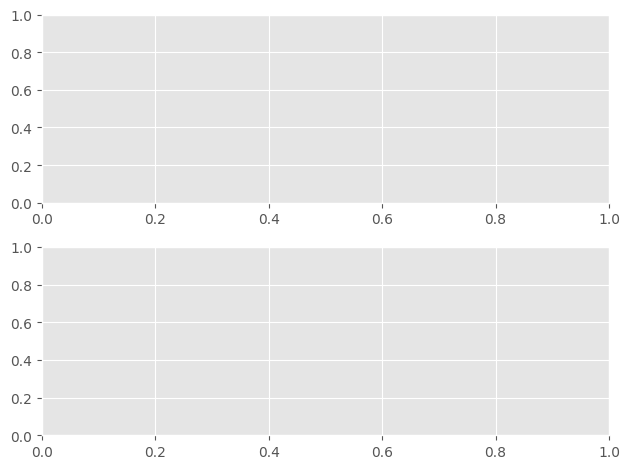

In [45]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')